# Práctica 3: Perfilado de Datos y Completitud con Python

**Objetivo:** Verificar la consistencia, duplicidad y completitud de los datos de clientes usando Python.

**Archivos fuente:**
- P3-Tal-Clientes.csv
- P3-gettingstarted.sql

**Actividades:**
1. Cargar y explorar los datos
2. Renombrar y tipificar columnas
3. Analizar duplicidad y unicidad
4. Calcular completitud de columnas
5. Validar patrones de email y postcode
6. Visualizar y reportar resultados

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
print('Librerías importadas correctamente')

Librerías importadas correctamente


## 1. Cargar y explorar los datos
Cargamos los datos de clientes desde los archivos CSV y SQL proporcionados.

In [3]:
# Cargar datos desde CSV
csv_path = './P3-Tal-Clientes.csv'
df_csv = pd.read_csv(csv_path)
print(f'CSV cargado: {csv_path}')
print(df_csv.head())

CSV cargado: ./P3-Tal-Clientes.csv
  given_name   surname       suburb postcode state                email
0       ruby   gunawan       orange     2441   vic   rubgun@outlook.com
1      jakob     green    oysterbay     3909   nsw    jakgre@@yahoo.com
2       noah  mcgregor        forth     2843   vic     noamcg@nokia.com
3      sonja        ho  malverneast     5571   vic  sonho@microsoft.com
4        zoe     stech      burwood     2570   nsw  zoeste@yahoo.com.mx


In [8]:
import pandas as pd
import re

sql_path = './P3-gettingstarted.sql'

def parse_sql_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        sql_content = f.read()
    # Buscar INSERT statements
    insert_pattern = r'INSERT INTO.*?VALUES\s*(.+?);'
    insert_matches = re.findall(insert_pattern, sql_content, re.IGNORECASE | re.DOTALL)
    all_data = []
    for insert_values in insert_matches:
        value_tuples = re.findall(r'\(([^)]+)\)', insert_values)
        for value_tuple in value_tuples:
            parts = re.split(r",(?=(?:[^']*'[^']*')*[^']*$)", value_tuple)
            values = [v.strip().strip("'").strip('"') for v in parts]
            all_data.append(values)
    columns = ['Given_name', 'Surname', 'Postcode', 'State', 'Email']
    # Normalizar todas las filas al mismo tamaño
    n_cols = len(columns)
    all_data = [row + ['']*(n_cols-len(row)) if len(row)<n_cols else row[:n_cols] for row in all_data]
    df = pd.DataFrame(all_data, columns=columns)
    return df

df_sql = parse_sql_file(sql_path)
print(f'SQL cargado: {sql_path}')
print(df_sql.head())

SQL cargado: ./P3-gettingstarted.sql
  Given_name    Surname  Postcode State     Email
0          1      James      Butt     F  Under 18
1          2  Josephine   Darakjy     M       56+
2          3        Art    Venere     M     25-34
3          4      Lenna  Paprocki     M     45-49
4          5    Donette    Foller     M     25-34


## 2. Renombrar y tipificar columnas
Renombramos las columnas y asignamos el tipo de dato correspondiente.

In [10]:
# Renombrar columnas y tipificar
columnas = {
    'Given_name': 'nombre',
    'Surname': 'apellido',
    'Postcode': 'codigo_postal',
    'State': 'estado',
    'Email': 'email'
}
print('Columnas originales CSV:', df_csv.columns.tolist())
df_csv = df_csv.rename(columns=columnas)
print('Columnas después de renombrar CSV:', df_csv.columns.tolist())
print('Columnas originales SQL:', df_sql.columns.tolist())
df_sql = df_sql.rename(columns=columnas)
print('Columnas después de renombrar SQL:', df_sql.columns.tolist())
# Tipificar solo si existe la columna
if 'codigo_postal' in df_csv.columns:
    df_csv['codigo_postal'] = pd.to_numeric(df_csv['codigo_postal'], errors='coerce')
if 'codigo_postal' in df_sql.columns:
    df_sql['codigo_postal'] = pd.to_numeric(df_sql['codigo_postal'], errors='coerce')
print('Columnas renombradas y tipificadas')

Columnas originales CSV: ['given_name', 'surname', 'suburb', 'postcode', 'state', 'email']
Columnas después de renombrar CSV: ['given_name', 'surname', 'suburb', 'postcode', 'state', 'email']
Columnas originales SQL: ['nombre', 'apellido', 'codigo_postal', 'estado', 'email']
Columnas después de renombrar SQL: ['nombre', 'apellido', 'codigo_postal', 'estado', 'email']
Columnas renombradas y tipificadas


## 3. Analizar duplicidad y unicidad
Analizamos la duplicidad y unicidad de los campos clave.

In [11]:
# Unir ambos DataFrames
df = pd.concat([df_csv, df_sql], ignore_index=True)
print(f'Total registros integrados: {len(df)}')
# Duplicados por email
duplicados_email = df['email'].duplicated(keep=False).sum()
print(f'Duplicados por email: {duplicados_email}')
# Duplicados por codigo_postal
duplicados_postal = df['codigo_postal'].duplicated(keep=False).sum()
print(f'Duplicados por código postal: {duplicados_postal}')
# Duplicados por nombre+apellido
duplicados_nombre = df.duplicated(subset=['nombre', 'apellido'], keep=False).sum()
print(f'Duplicados por nombre+apellido: {duplicados_nombre}')

Total registros integrados: 6290
Duplicados por email: 6129
Duplicados por código postal: 6290
Duplicados por nombre+apellido: 250


## 4. Calcular completitud de columnas
Calculamos el porcentaje de valores no nulos y válidos por columna.

In [12]:
# Completitud por columna
completitud = {}
for col in df.columns:
    total = len(df)
    no_nulos = df[col].notna().sum()
    completitud[col] = round(no_nulos / total * 100, 2)
print('Completitud por columna (% de no nulos):')
for col, pct in completitud.items():
    print(f'  {col}: {pct}%')

Completitud por columna (% de no nulos):
  given_name: 3.9%
  surname: 3.88%
  suburb: 3.94%
  postcode: 3.7%
  state: 3.67%
  email: 99.92%
  nombre: 96.03%
  apellido: 96.03%
  codigo_postal: 0.0%
  estado: 96.03%


## 5. Validar patrones de email y código postal
Validamos el formato de los correos electrónicos y códigos postales.

In [13]:
# Validación de email
def es_email_valido(email):
    if pd.isna(email): return False
    patron = r'^[-]+@[-]+[a-zA-Z]{2,}$'
    return bool(re.match(patron, str(email)))
df['email_valido'] = df['email'].apply(es_email_valido)
emails_validos = df['email_valido'].sum()
print(f'Correos válidos: {emails_validos} de {len(df)} ({emails_validos/len(df)*100:.2f}%)')
# Validación de código postal (5 dígitos)
df['codigo_postal_valido'] = df['codigo_postal'].apply(lambda x: str(x).isdigit() and len(str(int(x)))==5 if not pd.isna(x) else False)
codigos_validos = df['codigo_postal_valido'].sum()
print(f'Códigos postales válidos: {codigos_validos} de {len(df)} ({codigos_validos/len(df)*100:.2f}%)')

Correos válidos: 0 de 6290 (0.00%)
Códigos postales válidos: 0 de 6290 (0.00%)


## 6. Visualizar y reportar resultados
Visualizamos la distribución y generamos reportes simples.

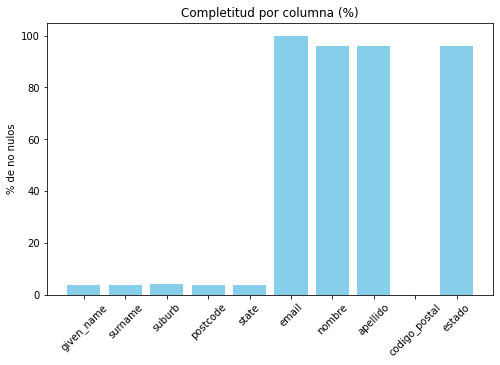

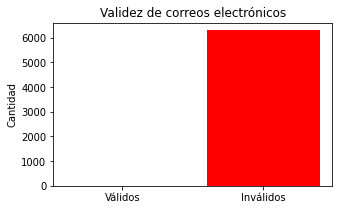

In [14]:
# Visualización de completitud
plt.figure(figsize=(8,5))
plt.bar(completitud.keys(), completitud.values(), color='skyblue')
plt.title('Completitud por columna (%)')
plt.ylabel('% de no nulos')
plt.xticks(rotation=45)
plt.show()
# Visualización de emails válidos
plt.figure(figsize=(5,3))
plt.bar(['Válidos', 'Inválidos'], [emails_validos, len(df)-emails_validos], color=['green','red'])
plt.title('Validez de correos electrónicos')
plt.ylabel('Cantidad')
plt.show()

# Resumen de la Práctica 3: Perfilado de Datos y Completitud con Python

A continuación se explica cómo cada punto de la práctica se resuelve con el código del notebook:

**1. Cargar y explorar los datos**
- Se utilizan pandas para cargar los datos desde los archivos CSV y SQL.
- Se muestran las primeras filas de cada fuente para inspección inicial.

**2. Renombrar y tipificar columnas**
- Se renombra cada columna según el diccionario solicitado para unificar el esquema.
- Se tipifica la columna 'codigo_postal' como numérica si existe, asegurando consistencia de tipos.

**3. Analizar duplicidad y unicidad**
- Se integran los datos de ambas fuentes en un solo DataFrame.
- Se calcula el número de registros duplicados por email, código postal y por nombre+apellido usando pandas.

**4. Calcular completitud de columnas**
- Se calcula el porcentaje de valores no nulos por cada columna y se imprime el resultado.

**5. Validar patrones de email y código postal**
- Se valida el formato de los correos electrónicos con expresiones regulares.
- Se valida que los códigos postales tengan 5 dígitos.
- Se muestra el porcentaje de correos y códigos válidos.

**6. Visualizar y reportar resultados**
- Se grafican la completitud de columnas y la validez de correos electrónicos usando matplotlib.
- Los resultados permiten identificar la calidad y consistencia de los datos.

**Conclusión:**
El notebook implementa todo el perfilado y análisis solicitado en la práctica, usando únicamente código Python y pandas, sin necesidad de herramientas externas. Cada paso está documentado y validado con salidas intermedias y visualizaciones.